In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as io
from skimage import feature
from skimage.transform import resize
from sklearn.feature_selection import VarianceThreshold
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sys
import os
sys.path.append('../')
import helpers.histogram_classifier as hc

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
PCA_components = 100

In [4]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [5]:
train, test = hc.split_data(image_names, 0.75)

In [6]:
def get_complete_features(image_classes, image_names, size):
    """
    Get RGB histogram, edge and corner features for a dictionary of image names
    :params image_classes: list of n image classes
    :params image_names: dictionary of m image names for each class
    :params size: size as tuple for reshaping images for extracting edges and corners
    :return: hist_features: array of RGB histogram features of shape (nm, 768)
    :return: edge_features: array of canny edge features of shape (nm, pq)
            where p, q are the dimensions in size parameter
    :return: corner_features: array of FAST corner features of shape (nm, pq)
            where p, q are the dimensions in size parameter
    :return: labels: array of true labels for each image
    """
    all_hist_features = []
    all_edge_features = []
    all_corner_features = []
    labels = []
    for c in image_classes:
        for i in image_names[c]:
            img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", i))
            all_hist_features.append(hc.color_histogram(img))
            img = rgb2gray(img)
            img = resize(img, size)
            all_edge_features.append(feature.canny(img, sigma=2))
            all_corner_features.append(feature.corner_fast(img, n=6, threshold=0.12))
            labels.append(c)
    hist_features = np.array(all_hist_features)
    edge_features = np.array(all_edge_features)
    corner_features = np.array(all_corner_features)
    
    return hist_features, edge_features.reshape(edge_features.shape[0], -1), corner_features.reshape(corner_features.shape[0], -1), np.array(labels)

In [7]:
#Get complete histogram features, edge and corners
all_hist_features, all_edge_features, all_corner_features, train_labels = get_complete_features(class_list, train, (90, 90))

In [8]:
#Remove variance from histogram features
hist_selector = VarianceThreshold()
hist_selector.fit(all_hist_features)
kept_histogram_features = hist_selector.transform(all_hist_features)

In [9]:
#Remove variance from edge features
edge_selector = VarianceThreshold()
edge_selector.fit(all_edge_features)
kept_edge_features = edge_selector.transform(all_edge_features)

In [10]:
#Remove variance from corner features
corner_selector = VarianceThreshold()
corner_selector.fit(all_corner_features)
kept_corner_features = corner_selector.transform(all_corner_features)

In [11]:
#Get top features using PCA for histogram features
color_pca = PCA(n_components=PCA_components)
color_pca.fit(kept_histogram_features)
final_histogram_features = color_pca.transform(kept_histogram_features)

In [12]:
#Get top features using PCA for edge features
edge_pca = PCA(n_components=PCA_components)
edge_pca.fit(kept_edge_features)
final_edge_features = edge_pca.transform(kept_edge_features)

In [13]:
#Get top features using PCA for corner features
corner_pca = PCA(n_components=PCA_components)
corner_pca.fit(kept_corner_features)
final_corner_features = corner_pca.transform(kept_corner_features)

In [14]:
final_kept_features = np.concatenate((final_histogram_features, final_edge_features, final_corner_features), axis=1)

In [15]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [16]:
grid.fit(final_kept_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  25,  50, 100]), 'max_depth': array([ 8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [17]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.2441111111111111
N_estimators: 100
Max depth: 8


In [52]:
%%time
#rf = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf = RandomForestClassifier(n_estimators=500, max_depth=8)
rf.fit(final_kept_features, train_labels)

CPU times: user 48.3 s, sys: 362 ms, total: 48.6 s
Wall time: 49.3 s


In [19]:
#Get Test Features
all_hist_features_t, all_edge_features_t, all_corner_features_t, test_labels = get_complete_features(class_list, test, (90, 90))

In [20]:
kept_hist_t_features = hist_selector.transform(all_hist_features_t)
kept_edge_t_features = edge_selector.transform(all_edge_features_t)
kept_corner_t_features = corner_selector.transform(all_corner_features_t)

In [21]:
final_hist_t_features = color_pca.transform(kept_hist_t_features)
final_edge_t_features = edge_pca.transform(kept_edge_t_features)
final_corner_t_features = corner_pca.transform(kept_corner_t_features)

In [22]:
final_test_features = np.concatenate((final_hist_t_features, final_edge_t_features, final_corner_t_features), axis=1)

In [53]:
%%time
predicted_labels = rf.predict(final_test_features)

CPU times: user 332 ms, sys: 64.3 ms, total: 396 ms
Wall time: 397 ms


In [54]:
%%time
predicted_probabilities = rf.predict_proba(final_test_features)

CPU times: user 309 ms, sys: 58.2 ms, total: 367 ms
Wall time: 366 ms


In [55]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [56]:
overall

,Accuracy,F1,Precision,Recall
Results,0.288,0.266,0.284,0.288


In [57]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.25,0.08,0.12,250.0
lasagna,0.32,0.11,0.17,250.0
french_toast,0.27,0.31,0.29,250.0
guacamole,0.34,0.46,0.39,250.0
apple_pie,0.22,0.15,0.18,250.0
cheesecake,0.24,0.42,0.31,250.0
hamburger,0.30,0.18,0.22,250.0
fried_rice,0.33,0.40,0.37,250.0
carrot_cake,0.27,0.11,0.16,250.0
chocolate_cake,0.29,0.51,0.37,250.0


In [58]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,19,9,29,24,12,32,9,16,8,41,34,17
lasagna,5,28,28,8,25,30,16,29,4,17,11,49
french_toast,5,8,77,16,7,21,11,23,6,18,20,38
guacamole,4,4,10,114,6,15,13,29,6,20,12,17
apple_pie,7,8,14,27,38,45,16,36,10,23,7,19
cheesecake,3,6,11,11,13,105,3,6,7,64,11,10
hamburger,8,4,27,25,17,18,45,25,5,18,18,40
fried_rice,1,3,11,27,16,14,16,101,5,12,7,37
carrot_cake,3,5,25,21,24,68,7,6,28,33,19,11
chocolate_cake,3,2,10,11,2,47,2,3,11,128,22,9


In [59]:
plt.style.use('ggplot')

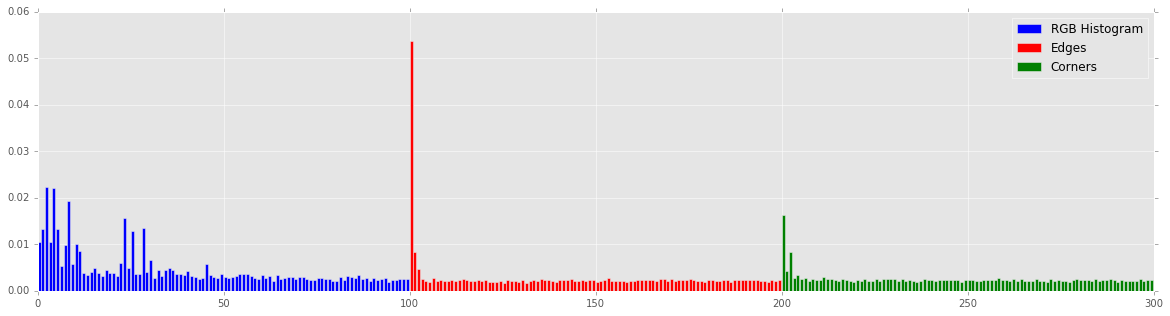

In [60]:
fig, ax = plt.subplots(figsize=(20,5))
# Number of different types of features
num_hist = final_histogram_features.shape[1]
num_edges = final_edge_features.shape[1]
num_corners = final_corner_features.shape[1]
ax.bar([i for i in range(num_hist)], rf.feature_importances_[:num_hist], color='blue', label='RGB Histogram')
ax.bar([i for i in range(num_hist, num_hist + num_edges)], rf.feature_importances_[num_hist:num_hist + num_edges], color='red', label='Edges')
ax.bar([i for i in range(num_hist + num_edges, num_hist + num_edges + num_corners)], rf.feature_importances_[num_hist + num_edges:], color='green', label='Corners')
#ax.set_title("Feature Importance")
ax.legend()
plt.show()